<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 2
---------------------------------------------------------------
Student numbers: <span style="color:red">r0703889, r0909802, r0716758, r0916443, r0822692</span>. 

In this group assignment your team will delve into some deep learning applications for computer vision. The assignment will be delivered in the same groups from *Group assignment 1* and you start from this template notebook. The notebook you submit for grading is the last notebook you submit in the [Kaggle competition](https://www.kaggle.com/t/d11be6a431b84198bc85f54ae7e2563f) prior to the deadline on **Tuesday 24 May 23:59**. Closely follow [these instructions](https://github.com/gourie/kaggle_inclass) for joining the competition, sharing your notebook with the TAs and making a valid notebook submission to the competition. A notebook submission not only produces a *submission.csv* file that is used to calculate your competition score, it also runs the entire notebook and saves its output as if it were a report. This way it becomes an all-in-one-place document for the TAs to review. As such, please make sure that your final submission notebook is self-contained and fully documented (e.g. provide strong arguments for the design choices that you make). Most likely, this notebook format is not appropriate to run all your experiments at submission time (e.g. the training of CNNs is a memory hungry and time consuming process; due to limited Kaggle resources). It can be a good idea to distribute your code otherwise and only summarize your findings, together with your final predictions, in the submission notebook. For example, you can substitute experiments with some text and figures that you have produced "offline" (e.g. learning curves and results on your internal validation set or even the test set for different architectures, pre-processing pipelines, etc). We advise you to first go through the PDF of this assignment entirely before you really start. Then, it can be a good idea to go through this notebook and use it as your first notebook submission to the competition. You can make use of the *Group assignment 2* forum/discussion board on Toledo if you have any questions. Good luck and have fun!

---------------------------------------------------------------
NOTES:
* This notebook is just a template. Please keep the five main sections, but feel free to adjust further in any way you please!
* Clearly indicate the improvements that you make! You can for instance use subsections like: *3.1. Improvement: applying loss function f instead of g*.


# 1. Overview
This assignment consists of *three main parts* for which we expect you to provide code and extensive documentation in the notebook:
* Image classification (Sect. 2)
* Semantic segmentation (Sect. 3)
* Adversarial attacks (Sect. 4)

In the first part, you will train an end-to-end neural network for image classification. In the second part, you will do the same for semantic segmentation. For these two tasks we expect you to put a significant effort into optimizing performance and as such competing with fellow students via the Kaggle competition. In the third part, you will try to find and exploit the weaknesses of your classification and/or segmentation network. For the latter there is no competition format, but we do expect you to put significant effort in achieving good performance on the self-posed goal for that part. Finally, we ask you to reflect and produce an overall discussion with links to the lectures and "real world" computer vision (Sect. 5). It is important to note that only a small part of the grade will reflect the actual performance of your networks. However, we do expect all things to work! In general, we will evaluate the correctness of your approach and your understanding of what you have done that you demonstrate in the descriptions and discussions in the final notebook.

## 1.1 Deep learning resources
If you did not yet explore this in *Group assignment 1 (Sect. 2)*, we recommend using the TensorFlow and/or Keras library for building deep learning models. You can find a nice crash course [here](https://colab.research.google.com/drive/1UCJt8EYjlzCs1H1d1X0iDGYJsHKwu-NO).

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import random
import cv2

## 1.2 PASCAL VOC 2009
For this project you will be using the [PASCAL VOC 2009](http://host.robots.ox.ac.uk/pascal/VOC/voc2009/index.html) dataset. This dataset consists of colour images of various scenes with different object classes (e.g. animal: *bird, cat, ...*; vehicle: *aeroplane, bicycle, ...*), totalling 20 classes.

The training set contains 749 examples.


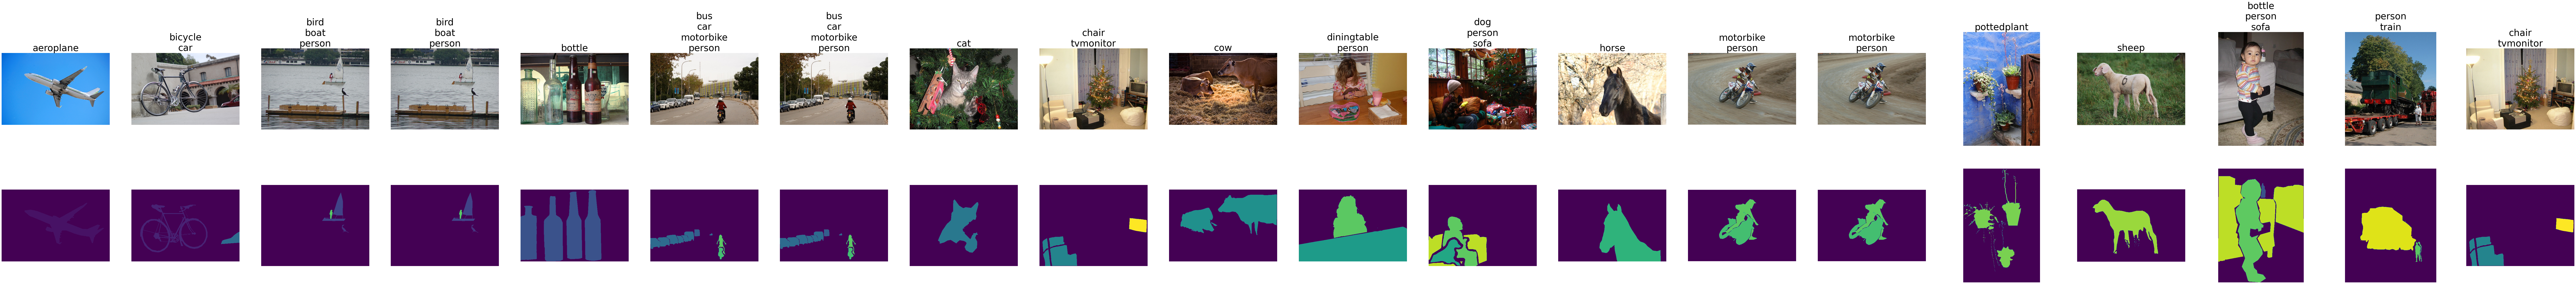

aeroplane  bicycle  bird  boat  bottle  bus  car  cat  chair  cow  ...  \
Id                                                                     ...   
0           0        0     0     0       0    0    0    0      0    1  ...   

    horse  motorbike  person  pottedplant  sheep  sofa  train  tvmonitor  \
Id                                                                         
0       0          0       0            0      0     0      0          0   

                                                  img  \
Id                                                      
0   [[[10, 8, 13], [16, 14, 19], [17, 14, 21], [19...   

                                                  seg  
Id                                                     
0   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  

[1 rows x 22 columns]

In [2]:
# Loading the training data
train_df = pd.read_csv('./kaggle/input/kul-h02a5a-computer-vision-ga2-2022/train/train_set.csv', index_col="Id")
labels = train_df.columns
train_df["img"] = [np.load('./kaggle/input/kul-h02a5a-computer-vision-ga2-2022/train/img/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
train_df["seg"] = [np.load('./kaggle/input/kul-h02a5a-computer-vision-ga2-2022/train/seg/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
print("The training set contains {} examples.".format(len(train_df)))

# Show some examples
fig, axs = plt.subplots(2, 20, figsize=(10 * 20, 10 * 2))
for i, label in enumerate(labels):
    df = train_df.loc[train_df[label] == 1]
    axs[0, i].imshow(df.iloc[0]["img"], vmin=0, vmax=255)
    axs[0, i].set_title("\n".join(label for label in labels if df.iloc[0][label] == 1), fontsize=40)
    axs[0, i].axis("off")
    axs[1, i].imshow(df.iloc[0]["seg"], vmin=0, vmax=20)  # with the absolute color scale it will be clear that the arrays in the "seg" column are label maps (labels in [0, 20])
    axs[1, i].axis("off")
    
plt.show()

# The training dataframe contains for each image 20 columns with the ground truth classification labels and 20 column with the ground truth segmentation maps for each class
train_df.head(1)

In [3]:
# Loading the test data
test_df = pd.read_csv('./kaggle/input/kul-h02a5a-computer-vision-ga2-2022/test/test_set.csv', index_col="Id")
test_df["img"] = [np.load('./kaggle/input/kul-h02a5a-computer-vision-ga2-2022/test/img/test_{}.npy'.format(idx)) for idx, _ in test_df.iterrows()]
test_df["seg"] = [-1 * np.ones(img.shape[:2], dtype=np.int8) for img in test_df["img"]]
print("The test set contains {} examples.".format(len(test_df)))

# The test dataframe is similar to the training dataframe, but here the values are -1 --> your task is to fill in these as good as possible in Sect. 2 and Sect. 3; in Sect. 6 this dataframe is automatically transformed in the submission CSV!
test_df.head(1)

The test set contains 750 examples.


aeroplane  bicycle  bird  boat  bottle  bus  car  cat  chair  cow  ...  \
Id                                                                     ...   
0          -1       -1    -1    -1      -1   -1   -1   -1     -1   -1  ...   

    horse  motorbike  person  pottedplant  sheep  sofa  train  tvmonitor  \
Id                                                                         
0      -1         -1      -1           -1     -1    -1     -1         -1   

                                                  img  \
Id                                                      
0   [[[139, 130, 115], [136, 127, 112], [112, 102,...   

                                                  seg  
Id                                                     
0   [[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...  

[1 rows x 22 columns]

## 1.3 Your Kaggle submission
Your filled test dataframe (during Sect. 2 and Sect. 3) must be converted to a submission.csv with two rows per example (one for classification and one for segmentation) and with only a single prediction column (the multi-class/label predictions running length encoded). You don't need to edit this section. Just make sure to call this function at the right position in this notebook.

In [4]:
def _rle_encode(img):
    """
    Kaggle requires RLE encoded predictions for computation of the Dice score (https://www.kaggle.com/lifa08/run-length-encode-and-decode)

    Parameters
    ----------
    img: np.ndarray - binary img array
    
    Returns
    -------
    rle: String - running length encoded version of img
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    return rle

def generate_submission(df):
    """
    Make sure to call this function once after you completed Sect. 2 and Sect. 3! It transforms and writes your test dataframe into a submission.csv file.
    
    Parameters
    ----------
    df: pd.DataFrame - filled dataframe that needs to be converted
    
    Returns
    -------
    submission_df: pd.DataFrame - df in submission format.
    """
    df_dict = {"Id": [], "Predicted": []}
    for idx, _ in df.iterrows():
        df_dict["Id"].append(f"{idx}_classification")
        df_dict["Predicted"].append(_rle_encode(np.array(df.loc[idx, labels])))
        df_dict["Id"].append(f"{idx}_segmentation")
        df_dict["Predicted"].append(_rle_encode(np.array([df.loc[idx, "seg"] == j + 1 for j in range(len(labels))])))
    
    submission_df = pd.DataFrame(data=df_dict, dtype=str).set_index("Id")
    submission_df.to_csv("submission.csv")
    return submission_df

# 2. Preprocessing the data

TODO: write some explenation about the preprocessing part

Balance, resize, normalise, filtering, if necessary converten to gray scale

In [5]:
def augmentData(data):
    labels = data.columns
    pp = labels.get_loc("person") ##Position person
    for i in range(data["img"].shape[0]):
        select= data.loc[i]
        if select[labels[pp]]==0:
        
            FLR = select.copy()
            FLR["img"] = np.array(tf.image.flip_left_right(FLR["img"]))
            FLR["seg"] = np.array(tf.image.flip_left_right(tf.expand_dims(FLR["seg"],axis=2)))
            data = data.append(FLR,ignore_index=True)
        
            FUD = select.copy()
            FUD["img"] = np.array(tf.image.flip_up_down(FUD["img"]))
            FUD["seg"] = np.array(tf.image.flip_up_down(tf.expand_dims(FUD["seg"],axis=2)))
            data = data.append(FUD,ignore_index=True)
        
            B = select.copy()
            B["img"] = np.array(tf.image.random_brightness(B["img"],0.6, seed=None))
            data = data.append(B,ignore_index=True)
    return data

In [6]:
def removeData(data):
    arr = data['person'].to_numpy()
    arrPersons = []
    for i in range(len(arr)):
        if(data['person'][i] == 1):
            arrPersons.append(i)

    newPerson = random.sample(arrPersons, 120)
    newData = data.drop(newPerson, axis=0, inplace=False)
    newData.reset_index(inplace=True)
    return newData

In [7]:
class Preprocessor:
    
    def __init__(self, img_size, toGray, test):
        self.img_size = img_size
        self.width = self.img_size[1]
        self.height = self.img_size[0]
        self.toGray = toGray
        self.test = test
        
    def resize(self,img):
        resized = cv2.resize(img, (self.width,self.height), interpolation = cv2.INTER_AREA)
        return resized
    
    def normalization(self,gray_img):
        img = gray_img / 255.0
        return img
    
    def Filter(self,img,filter):
        if filter=='Gaussian':
            img = cv2.GaussianBlur(img,(5,5),cv2.BORDER_DEFAULT)
        elif filter=='Median':
            img = cv2.medianBlur(img,5)
        else:
            raise Error
            
        return img
    
    def preprocess(self,data):
        preprocData = data.copy()
        images = data["img"]
        segmentations = data["seg"]
        nb_images = images.shape[0]
        for i in range(nb_images):
            image = images[i]
            seg = segmentations[i]
            # Resize both img and seg
            image = self.resize(image)
            if self.test == False:
                seg = self.resize(seg)
            # Switch to grayscale
            if self.toGray == True:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # Normalization
            normalized_img = self.normalization(image)
            # Filter 
            blur_img = self.Filter(normalized_img,'Gaussian')
            img = tf.convert_to_tensor(blur_img)
            seg = tf.convert_to_tensor(seg)
            images[i]=img
            segmentations[i]=seg
            
        preprocData['img'] = images
        preprocData['seg'] = segmentations
        return preprocData
    
    def __call__(self, data):
        return self.preprocess(data)
        

def FindLargestDim(data):
    imgs = data['img']
    x_max = 0
    y_max = 0
    for img in imgs:
        x,y,_ = img.shape
        if x>x_max:
            x_max=x
        if y>y_max:
            y_max=y
    return (x_max,y_max)

In [8]:
# Balance data set
# Choose if you want to use images with 3 dimensions (in RGB) or the grayscale images
# For transfer learning we need images in RGB values
toGray = False
preprocessed_train_df = train_df.copy()
test = False

if toGray == True:                   # Since the images are gray, we can add some artificial data
    preprocessed_train_df = augmentData(train_df)
else:                                # Images take to much space to augment, thus we remove some images to balance the dataset
    preprocessed_train_df = removeData(train_df)
    
dim = FindLargestDim(preprocessed_train_df)
preprocessor = Preprocessor(dim, toGray, test)
preprocessed_train_df = preprocessor(preprocessed_train_df)

C:\Users\Pili\.julia\conda\3\envs\CV\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Pili\.julia\conda\3\envs\CV\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


749
629
(500, 500, 3)


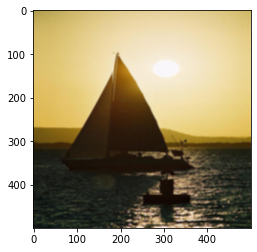

In [9]:
print(len(train_df['img']))
print(len(preprocessed_train_df['img']))
print(preprocessed_train_df['img'][600].shape)
plt.imshow(preprocessed_train_df['img'][600])

In [10]:
# checking how balanced the dataset becomes after preprocessing
for i in range(len(preprocessed_train_df.columns)-2):
    arr = preprocessed_train_df[preprocessed_train_df.columns[i]].to_numpy()
    amount = np.count_nonzero(arr == 1)

    print('Number of', preprocessed_train_df.columns[i], ':', amount)

Number of Id : 1
Number of aeroplane : 44
Number of bicycle : 23
Number of bird : 52
Number of boat : 44
Number of bottle : 32
Number of bus : 32
Number of car : 51
Number of cat : 43
Number of chair : 59
Number of cow : 26
Number of diningtable : 34
Number of dog : 39
Number of horse : 35
Number of motorbike : 37
Number of person : 87
Number of pottedplant : 36
Number of sheep : 26
Number of sofa : 40
Number of train : 38
Number of tvmonitor : 40


Now the images need to be put in datastructures which are compatible with the CNN's used

output is a so called one-hot encoding. One-hot encoding can be used when as loss the categorical-entropy wordt gebruikt

In [11]:
SIZE_IMG = 500

y = preprocessed_train_df[['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']]
train_y = y.to_numpy()
print(train_y)

# reshape images 
# input images should have a shape [batch_size, img_height, img_width, number_of_channels]
numberOfIm = len(preprocessed_train_df["img"])
if toGray == True:
    dimIm = 1
else:
    dimIm = 3
    
train_x = np.array(np.zeros([numberOfIm, SIZE_IMG, SIZE_IMG, dimIm]))
for i in range(numberOfIm):
    Im = preprocessed_train_df["img"][i]
    A = np.asarray(Im).reshape(SIZE_IMG,SIZE_IMG,dimIm)
    train_x[i,:,:,:] = A

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 1 ... 0 0 0]]


Same preprocess procedure for the test data

In [12]:
# same preprocessing procedure for the test data
test = True

preprocessed_test_df = test_df.copy()
dim = FindLargestDim(test_df)
preprocessor = Preprocessor(dim, toGray, test)
preprocessed_test_df = preprocessor(test_df)

C:\Users\Pili\.julia\conda\3\envs\CV\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Pili\.julia\conda\3\envs\CV\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(500, 500, 3)
750


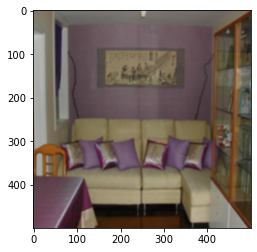

In [13]:
print(preprocessed_test_df['img'][2].shape)
print(len(preprocessed_test_df['img']))
plt.imshow(preprocessed_test_df['img'][2])

In [14]:
# reshape images 
# input images should have a shape [batch_size, img_height, img_width, number_of_channels]
numberOfIm = len(preprocessed_test_df["img"])
test = np.array(np.zeros([numberOfIm, SIZE_IMG, SIZE_IMG, dimIm]))
for i in range(numberOfIm):
    Im = preprocessed_test_df["img"][i]
    A = np.asarray(Im).reshape(SIZE_IMG,SIZE_IMG,dimIm)
    test[i,:,:,:] = A

In [15]:
print(test.shape)

(750, 500, 500, 3)


# 3. Image classification
The goal here is simple: implement a classification CNN and train it to recognise all 20 classes (and/or background) using the training set and compete on the test set (by filling in the classification columns in the test dataframe).

In [16]:
class RandomClassificationModel:
    """
    Random classification model: 
        - generates random labels for the inputs based on the class distribution observed during training
        - assumes an input can have multiple labels
    """
    def fit(self, X, y):
        """
        Adjusts the class ratio variable to the one observed in y. 

        Parameters
        ----------
        X: list of arrays - n x (height x width x 3)
        y: list of arrays - n x (nb_classes)

        Returns
        -------
        self
        """
        self.distribution = np.mean(y, axis=0)
        print("Setting class distribution to:\n{}".format("\n".join(f"{label}: {p}" for label, p in zip(labels, self.distribution))))
        return self
        
    def predict(self, X):
        """
        Predicts for each input a label.
        
        Parameters
        ----------
        X: list of arrays - n x (height x width x 3)
            
        Returns
        -------
        y_pred: list of arrays - n x (nb_classes)
        """
        np.random.seed(0)
        return [np.array([int(np.random.rand() < p) for p in self.distribution]) for _ in X]
    
    def __call__(self, X):
        return self.predict(X)
    
randomModel = RandomClassificationModel()
randomModel.fit(train_df["img"], train_df[labels])
test_df.loc[:, labels] = randomModel.predict(test_df["img"])
test_df.head(1)

Setting class distribution to:
aeroplane: 0.06275033377837116
bicycle: 0.0520694259012016
bird: 0.07343124165554073
boat: 0.06408544726301736
bottle: 0.056074766355140186
bus: 0.050734312416555405
car: 0.08411214953271028
cat: 0.06008010680907877
chair: 0.09212283044058744
cow: 0.04005340453938585
diningtable: 0.06408544726301736
dog: 0.05740987983978638
horse: 0.056074766355140186
motorbike: 0.06275033377837116
person: 0.27636849132176233
pottedplant: 0.05740987983978638
sheep: 0.036048064085447265
sofa: 0.05874499332443257
train: 0.0534045393858478
tvmonitor: 0.06809078771695594


aeroplane  bicycle  bird  boat  bottle  bus  car  cat  chair  cow  ...  \
Id                                                                     ...   
0           0        0     0     0       0    0    0    0      0    0  ...   

    horse  motorbike  person  pottedplant  sheep  sofa  train  tvmonitor  \
Id                                                                         
0       0          0       1            0      1     0      0          0   

                                                  img  \
Id                                                      
0   (((tf.Tensor(0.5243602460449382, shape=(), dty...   

                                                  seg  
Id                                                     
0   ((tf.Tensor(-1, shape=(), dtype=int8), tf.Tens...  

[1 rows x 22 columns]

## 3.1 Image classification from scratch

### Model 1

The goal here is simple: implement a classification CNN and train it to recognise all 20 classes (and/or background) using the training set and compete on the test set (by filling in the classification columns in the test dataframe).

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [51]:
# import necessary packages
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

Using TensorFlow backend.


In [52]:
# model that was proposed in the blog
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu" , input_shape = (SIZE_IMG,SIZE_IMG,1)) ,
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    # added
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu") ,  
    tf.keras.layers.AveragePooling2D(2,2),
    
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(64,activation="relu"),      #Adding the Hidden layer
    tf.keras.layers.Dropout(0.2, seed = 2019),
    tf.keras.layers.Dense(20,activation = "sigmoid")   #Adding the Output Layer
])

In [ ]:
# Model 2
## This is the first model we tried, the predictions are not that good. After 1 epoch overfit
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation = "relu" , input_shape = (500,500,1)) ,
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu"),  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(550,activation="relu"),      #Adding the Hidden layer
    tf.keras.layers.Dropout(0.1,seed = 2019),
    #tf.keras.layers.Dense(400,activation ="relu"),
    #tf.keras.layers.Dropout(0.3,seed = 2019),
    #tf.keras.layers.Dense(300,activation="relu"),
    #tf.keras.layers.Dropout(0.4,seed = 2019),
    #tf.keras.layers.Dense(200,activation ="relu"),
    #tf.keras.layers.Dropout(0.2,seed = 2019),
    tf.keras.layers.Dense(20,activation = "sigmoid")   #Adding the Output Layer: kleine getalletjes want absolute kansen (softmaxgeeft relatieve kansen, dus is niet dat hij heel onaccuraat is)
])

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 498, 498, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 247, 247, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 121, 121, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 64)        3

[COPYRIGHT] So far, we've seen RMSProp and Momentum take contrasting approaches. While momentum accelerates our search in direction of minima, RMSProp impedes our search in direction of oscillations. Adam or Adaptive Moment Optimization algorithms combines the heuristics of both Momentum and RMSProp.


In [54]:
# binary cross entropy: multiple labels per photo 1 000.  11000
from tensorflow.keras.optimizers import RMSprop,SGD,Adam

# TODO: overfit wrsch: binary of cross: want hoe bepaal je accuracty en loss nu? want multilabel nu, 
# maar kijkt hij naar 1 of 2 values nu?
# probleem: val los wordt hoger ipv lager$

# adam: lr groot -> verklein. 0.1 -> 0.001 -> 0.000001
# wat is rmsprop -> opzoeken (adam goed)
adam = Adam(lr=0.01)

model.compile(#optimizer='rmsprop',
              optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [55]:
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

checkpoint_filepath = 'checkpoint.h5'
# Model weights are saved at the end of every epoch, if it's the best seen so far.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


history = model.fit(train_x, train_y, validation_split=0.2, epochs=1, batch_size=32, verbose=1, callbacks=[callback, model_checkpoint_callback])

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

model.save('pierre_model.h5')

Train on 1900 samples, validate on 475 samples
1900/1900 [==============================] - 406s 214ms/sample - loss: 0.3245 - accuracy: 0.8933 - val_loss: 0.2362 - val_accuracy: 0.9393


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


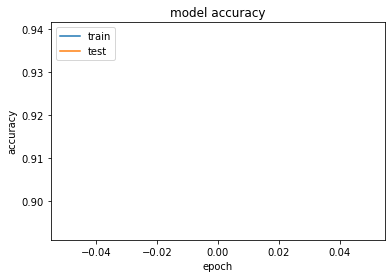

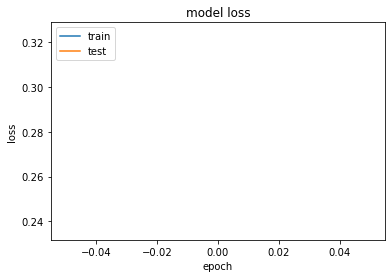

In [56]:
# plotting the accuracy and loss functions
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])   # Terug toeveogen wanneer validatieset hebben
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
import keras
model = keras.models.load_model('ModelFromScracth.h5')

TypeError: __init__() got an unexpected keyword argument 'ragged'

In [58]:
# make a prediction on the test set
yhat = model.predict(test)

In [59]:
# choose threshold to convert to zero's and ones
yhat = yhat > 0.1
yhat = yhat.astype(int)

In [60]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

yhat

array([[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0,

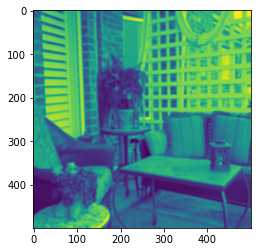

In [61]:
## Testing with 1 image
plt.imshow(test_df["img"][1])

In [62]:
testImage = test[1,:,:,:]
pred = model.predict(testImage.reshape(1,500,500,1))

In [63]:
print(pred)
print(np.argmax(pred))
top = np.argsort(pred)[:-4:-1]
print(top)
for i in range(len(top)):
    index = top[i]
    print(train_df.columns[index])

[[0.1178117  0.06166532 0.08506481 0.11490627 0.04717804 0.04253561
  0.09515406 0.04902628 0.06409047 0.06601934 0.0476311  0.06687828
  0.06771073 0.06865358 0.12581354 0.06024707 0.04264934 0.03389106
  0.07505488 0.05266004]]
14
[[17  5 16  4 10  7 19 15  1  8  9 11 12 13 18  2  6  3  0 14]]
Index(['sofa', 'bus', 'sheep', 'bottle', 'diningtable', 'cat', 'tvmonitor',
       'pottedplant', 'bicycle', 'chair', 'cow', 'dog', 'horse', 'motorbike',
       'train', 'bird', 'car', 'boat', 'aeroplane', 'person'],
      dtype='object')


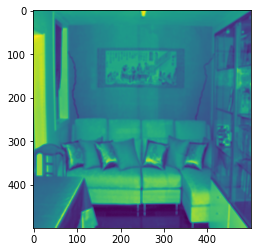

In [64]:
plt.imshow(test_df["img"][2])

In [65]:
testImage2 = test[2,:,:,:]
pred = model.predict(testImage2.reshape(1,500,500,1))

In [66]:
print(pred)
print(np.argmax(pred))
top = np.argsort(pred)[:-4:-1]
print(top)
for i in range(len(top)):
    index = top[i]
    print(train_df.columns[index])

[[0.13136205 0.07308976 0.0979768  0.12837137 0.0579243  0.05187884
  0.10992917 0.06067944 0.07673137 0.0790109  0.05861081 0.0798175
  0.07917716 0.07969171 0.14328039 0.07203495 0.05384856 0.04211461
  0.08775377 0.06501115]]
14
[[17  5 16  4 10  7 19 15  1  8  9 12 13 11 18  2  6  3  0 14]]
Index(['sofa', 'bus', 'sheep', 'bottle', 'diningtable', 'cat', 'tvmonitor',
       'pottedplant', 'bicycle', 'chair', 'cow', 'horse', 'motorbike', 'dog',
       'train', 'bird', 'car', 'boat', 'aeroplane', 'person'],
      dtype='object')


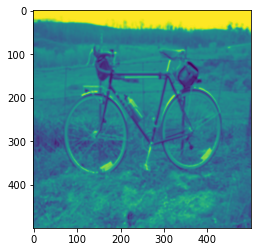

In [67]:
plt.imshow(test_df["img"][3])

In [68]:
testImage3 = test[3,:,:,:]
pred = model.predict(testImage2.reshape(1,500,500,1))

In [69]:
print(pred)
print(np.argmax(pred))
top = np.argsort(pred)[:-4:-1]
print(top)
for i in range(len(top)):
    index = top[i]
    print(train_df.columns[index])

[[0.13136205 0.07308976 0.0979768  0.12837137 0.0579243  0.05187884
  0.10992917 0.06067944 0.07673137 0.0790109  0.05861081 0.0798175
  0.07917716 0.07969171 0.14328039 0.07203495 0.05384856 0.04211461
  0.08775377 0.06501115]]
14
[[17  5 16  4 10  7 19 15  1  8  9 12 13 11 18  2  6  3  0 14]]
Index(['sofa', 'bus', 'sheep', 'bottle', 'diningtable', 'cat', 'tvmonitor',
       'pottedplant', 'bicycle', 'chair', 'cow', 'horse', 'motorbike', 'dog',
       'train', 'bird', 'car', 'boat', 'aeroplane', 'person'],
      dtype='object')


## 3.2 Image classification with transfer learning

In [17]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50

In [18]:
numClasses = 20
transferModel = Sequential()
transferModel.add(ResNet50(include_top=False, input_shape=(500, 500, 3)))
transferModel.add(Flatten())
transferModel.add(Dense(numClasses, activation='sigmoid'))
transferModel.layers[0].trainable = False

In [19]:
transferModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 16, 16, 2048)      23587712  
_________________________________________________________________
flatten (Flatten)            (None, 524288)            0         
_________________________________________________________________
dense (Dense)                (None, 20)                10485780  
Total params: 34,073,492
Trainable params: 10,485,780
Non-trainable params: 23,587,712
_________________________________________________________________


In [20]:
adam=tf.keras.optimizers.Adam(lr=0.001)
transferModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

checkpoint_filepath = 'checkpoint.h5'
# Model weights are saved at the end of every epoch, if it's the best seen so far.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


history = transferModel.fit(train_x, train_y, validation_split=0.2, epochs=1, batch_size=32, verbose=1, callbacks=[callback, model_checkpoint_callback])

Train on 503 samples, validate on 126 samples
 96/503 [====>.........................] - ETA: 17:14 - loss: 15.5971 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


KeyboardInterrupt: 

In [24]:
# plotting the accuracy and loss functions
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])   # Terug toeveogen wanneer validatieset hebben
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

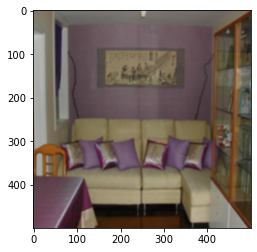

In [25]:
plt.imshow(test_df["img"][2])

In [26]:
testImage = test[2,:,:,:]
pred = transferModel.predict(testImage.reshape(1,500,500,3))
top = np.argsort(pred)[:-4:-1]
for i in range(len(top)):
    index = top[i]
    print(train_df.columns[index])

Index(['cow', 'sofa', 'sheep', 'pottedplant', 'motorbike', 'horse', 'dog',
       'diningtable', 'train', 'tvmonitor', 'cat', 'bus', 'bottle', 'boat',
       'bird', 'bicycle', 'car', 'aeroplane', 'person', 'chair'],
      dtype='object')


# 3. Semantic segmentation
The goal here is to implement a segmentation CNN that labels every pixel in the image as belonging to one of the 20 classes (and/or background). Use the training set to train your CNN and compete on the test set (by filling in the segmentation column in the test dataframe).

In [ ]:
class RandomSegmentationModel:
    """
    Random segmentation model: 
        - generates random label maps for the inputs based on the class distributions observed during training
        - every pixel in an input can only have one label
    """
    def fit(self, X, Y):
        """
        Adjusts the class ratio variable to the one observed in Y. 

        Parameters
        ----------
        X: list of arrays - n x (height x width x 3)
        Y: list of arrays - n x (height x width)

        Returns
        -------
        self
        """
        self.distribution = np.mean([[np.sum(Y_ == i) / Y_.size for i in range(len(labels) + 1)] for Y_ in Y], axis=0)
        print("Setting class distribution to:\nbackground: {}\n{}".format(self.distribution[0], "\n".join(f"{label}: {p}" for label, p in zip(labels, self.distribution[1:]))))
        return self
        
    def predict(self, X):
        """
        Predicts for each input a label map.
        
        Parameters
        ----------
        X: list of arrays - n x (height x width x 3)
            
        Returns
        -------
        Y_pred: list of arrays - n x (height x width)
        """
        np.random.seed(0)
        return [np.random.choice(np.arange(len(labels) + 1), size=X_.shape[:2], p=self.distribution) for X_ in X]
    
    def __call__(self, X):
        return self.predict(X)
    
model = RandomSegmentationModel()
model.fit(train_df["img"], train_df["seg"])
test_df.loc[:, "seg"] = model.predict(test_df["img"])
test_df.head(1)

## Submit to competition
You don't need to edit this section. Just use it at the right position in the notebook. See the definition of this function in Sect. 1.3 for more details.

In [60]:
# export solutions to good format
test_df.loc[:, labels] = yhat
test_df.head(1)

aeroplane  bicycle  bird  boat  bottle  bus  car  cat  chair  cow  ...  \
Id                                                                     ...   
0           1        1     0     0       0    0    1    0      0    0  ...   

    horse  motorbike  person  pottedplant  sheep  sofa  train  tvmonitor  \
Id                                                                         
0       0          0       1            0      0     0      1          1   

                                                  img  \
Id                                                      
0   ((tf.Tensor(0.4773014225155265, shape=(), dtyp...   

                                                  seg  
Id                                                     
0   ((tf.Tensor(-1, shape=(), dtype=int8), tf.Tens...  

[1 rows x 22 columns]

In [61]:
generate_submission(test_df)

Predicted
Id                                            
0_classification        1 2 7 1 12 1 15 1 19 2
0_segmentation                                
1_classification        2 1 7 1 12 1 15 1 19 2
1_segmentation                                
2_classification    1 2 4 1 7 1 12 2 15 1 19 2
...                                        ...
747_segmentation                              
748_classification      1 4 6 2 12 2 15 1 18 3
748_segmentation                              
749_classification  1 2 4 1 7 1 12 2 15 1 19 2
749_segmentation                              

[1500 rows x 1 columns]

# 4. Adversarial attack
For this part, your goal is to fool your classification and/or segmentation CNN, using an *adversarial attack*. More specifically, the goal is build a CNN to perturb test images in a way that (i) they look unperturbed to humans; but (ii) the CNN classifies/segments these images in line with the perturbations.

### Fast Gradient Sign Method

In [27]:
from tensorflow.keras.losses import MSE
import tensorflow as tf

In [87]:
def generate_image_adversary(model, image, label, eps=2 / 255.0):
    # cast the image
    image = tf.cast(image, tf.float32)
    # record our gradients
    with tf.GradientTape() as tape:
        # explicitly indicate that our image should be tacked for gradient updates
        tape.watch(image)
        # use our model to make predictions on the input image and then compute the loss   
        pred = model(tf.reshape(image, (1,500,500,3)))
        loss = MSE(label, pred)
    # calculate the gradients of loss with respect to the image, then compute the sign of the gradient
    gradient = tape.gradient(loss, image)
    signedGrad = tf.sign(gradient)
    # construct the image adversary
    adversary = (image + (signedGrad * eps)).numpy()
    # return the image adversary to the calling function
    return adversary

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
cow


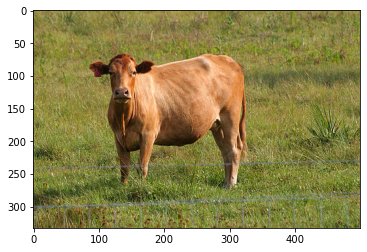

In [82]:
plt.imshow(train_df["img"][4])
top = np.argsort(train_y[4])[:-2:-1]
print(train_y[4])
for i in range(len(top)):
    index = top[i]
    print(train_df.columns[index])

In [83]:
testImage = train_x[4,:,:,:]
pred = transferModel.predict(testImage.reshape(1,500,500,3))
top = np.argsort(pred[0])[:-2:-1]
for i in range(len(top)):
    index = top[i]
    print(train_df.columns[index])

chair


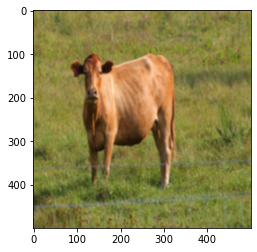

In [89]:
adversary = generate_image_adversary(transferModel, testImage, train_y[10], eps=0.1)
plt.imshow(adversary)

In [91]:
predAdv = transferModel.predict(tf.reshape(adversary, (1,500,500,3)))

In [92]:
top = np.argsort(predAdv[0])[:-2:-1]
for i in range(len(top)):
    index = top[i]
    print(train_df.columns[index])

chair


# 5. Discussion
Finally, take some time to reflect on what you have learned during this assignment. Reflect and produce an overall discussion with links to the lectures and "real world" computer vision.